<a href="https://colab.research.google.com/github/luanakwon/ML_Pytorch_pre2022/blob/main/ProGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

trying the concept of progressive GAN

In [ ]:
# paper link
# https://arxiv.org/pdf/1710.10196.pdf
# celebA dataset
# 'drive/MyDrive/Dataset/celebA'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optimizer
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
current_epoch = 0
epoch = 50
lr = 0.00012
batch_size = 32
z_len = 512

image_size = 128
max_step = 5

device = torch.device('cuda') if (torch.cuda.is_available())else torch.device('cpu')

load_checkpoint = True
CHECKPOINT_SAVE_PATH = 'drive/MyDrive/NN_saves/checkpoints/ProGAN_PR1/'
CHECKPOINT_LOAD_PATH = 'drive/MyDrive/NN_saves/checkpoints/ProGAN_PR1/ProGAN_CP_0602_1046.pth'

In [ ]:
dataset = dsets.ImageFolder(root='drive/MyDrive/Dataset/celebA',
                            transform=transforms.Compose([
                            transforms.CenterCrop((178,178)),
                            transforms.Resize(image_size),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))                             
                            ]))
print(dataset)

dataloader = DataLoader(dataset,batch_size=batch_size,
                        shuffle=True,num_workers=2,drop_last=True)

b_len = len(dataloader)

# for i, j in enumerate(dataloader):
#   print(f'\r {i}',end=' ')

Dataset ImageFolder
    Number of datapoints: 55001
    Root location: drive/MyDrive/Dataset/celebA
    StandardTransform
Transform: Compose(
               CenterCrop(size=(178, 178))
               Resize(size=128, interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [ ]:
def init_weight(m):
  if type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d:
    nn.init.normal_(m.weight.data,std=0.02)

In [ ]:
def image_down_sampler(x,output_size):
  k = int(x.shape[3]/output_size)
  layer = nn.AvgPool2d(k,k)
  return layer(x)

# x = torch.ones((8,3,8,8))
# y = image_down_sampler(x,4)
# print(y.shape)

In [ ]:
class StepScheduler():
  def __init__(self,epoch,b_len,steps):
    self.epoch = epoch
    self.b_len = b_len
    self.max_step = steps
    self.c_substep = 0
    self.a_count = 0
    self.step_width = int(epoch/(steps*2 + 1))

  def getStep(self,e):
    s = int(e/self.step_width)
    if self.c_substep != s:
      self.a_count = 0
    self.c_substep = s
    s = int((s+1)/2)
    if s > self.max_step:
      return (False,s)
    return (True,s)

  def getNextAlpha(self):
    if self.c_substep%2 == 0:
      alpha = 1
    else:
      alpha = self.a_count / (self.step_width * self.b_len)
      self.a_count += 1
    return alpha
    

    

In [ ]:
class ConvLayerUp(nn.Module):
  def __init__(self, channels):
    super().__init__()

    self.upsample = nn.Upsample(scale_factor=(2,2))
    self.conv_layers = nn.Sequential(
        nn.Conv2d(channels[0],channels[1],3,1,1),
        nn.BatchNorm2d(channels[1]),
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(channels[1],channels[2],3,1,1),
        nn.BatchNorm2d(channels[2]),
        nn.LeakyReLU(0.2,True)
        # pixelNorm
    )
  def forward(self,in_tuple):#(flag=True,x,output_size)
    flag,x,output_size = in_tuple
    output_size //= 2
    if flag:
      diff = x.shape[2] - output_size
      if diff < 0:
        x = self.upsample(x)
        x = self.conv_layers(x)
        return (True, x, output_size*2)
      elif diff == 0:
        out1 = self.upsample(x)
        out2 = self.conv_layers(out1)
        return (False,(out1, out2),output_size*2)
    else:
      return in_tuple
    

In [ ]:
class ConvLayerDown(nn.Module):
  def __init__(self, channels, in_size):
    super().__init__()
    self.in_size = in_size
    self.downsample = nn.AvgPool2d((2,2))
    self.conv_layers = nn.Sequential(
        nn.Conv2d(channels[0],channels[1],3,1,1),
        # nn.BatchNorm2d(channels[1]),
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(channels[1],channels[2],3,1,1),
        # nn.BatchNorm2d(channels[2]),
        nn.LeakyReLU(0.2,True)
        # pixelNorm
    )
  def forward(self,in_tuple):#(x,x_res,alpha)
    x,x_res,alpha = in_tuple
    if x.shape[2] == self.in_size:
      x = self.conv_layers(x)
      x = self.downsample(x)
      if x.shape[2] == x_res.shape[2]:
        x = x * alpha + x_res * (1 - alpha)
      return (x,x_res,alpha)
    else:
      return in_tuple      

In [ ]:
class ToRGB(nn.Module):
  def __init__(self,in_channels):
    super().__init__()
    self.in_channels = in_channels
    self.layer = nn.Conv2d(in_channels,3,1,1)

  def forward(self,x):
    if x.shape[1] == self.in_channels:
      x = self.layer(x)
      x = torch.tanh(x)
    return x

In [ ]:
class FromRGB(nn.Module):
  def __init__(self,out_channels):
    super().__init__()
    self.out_channels = out_channels
    self.layer = nn.Conv2d(3,out_channels,1,1)

  def forward(self, in_tuple):
    x, out_channels = in_tuple
    if out_channels == self.out_channels:
      x = self.layer(x)
      x = torch.tanh(x)
    return (x, out_channels)

In [ ]:
class Generator(nn.Module):
  def __init__(self,hidden_channels):
    super().__init__()

    self.first_layer = nn.Sequential(
        # 512,1,1
        nn.Upsample(scale_factor = (7,7)),
        nn.Conv2d(512,512,4),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,True),
        nn.Conv2d(512,512,3,1,1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,True)
    )

    h = []
    for ich,och in zip(hidden_channels[:-1],hidden_channels[1:]):
      h.append(ConvLayerUp((ich,och,och)))
    self.hidden_layer = nn.Sequential(*h)

    r = []
    for c in range(4,10):
      r.append(ToRGB(2**c))
    self.toRGB = nn.Sequential(*r)

  def forward(self,x,alpha,out_size):
    x = x.view(x.shape[0],512,1,1)
    x = self.first_layer(x)
    if out_size > 4:
      out = self.hidden_layer((True,x,out_size))
      out1, out2 = out[1]
      out1 = self.toRGB(out1)
      out2 = self.toRGB(out2)
      return out1 * (1 - alpha) + out2 * alpha
    else:
      return self.toRGB(x)



In [ ]:
class Discriminator(nn.Module):
  def __init__(self,hidden_channels):
    super().__init__()

    self.channel_map = dict()
    i = len(hidden_channels) + 1
    for ch in hidden_channels:
      self.channel_map[2**i] = ch
      i -= 1

    h = []
    i = len(hidden_channels) + 1
    for ich,och in zip(hidden_channels[:-1],hidden_channels[1:]):
      h.append(ConvLayerDown((ich,ich,och),2**i))
      i -= 1
    self.hidden_layer = nn.Sequential(*h)

    r = []
    for c in range(4,10):
      r.append(FromRGB(2**c))
    self.fromRGB = nn.Sequential(*r)

    self.downsample = nn.AvgPool2d((2,2))

    self.last_layer = nn.Sequential(
        nn.Conv2d(512,512,3,1,1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,True),
        nn.Conv2d(512,512,4,1),
        nn.LeakyReLU(0.2,True)
    )
    self.fc = nn.Sequential(
        nn.Linear(512,1),
        nn.Sigmoid()
    )
    
  def forward(self,x,alpha):
    if x.shape[2] > 4:
      x_res = self.downsample(x)
      x_res,_ = self.fromRGB((x_res,self.channel_map[x_res.shape[2]]))
      x,_ = self.fromRGB((x,self.channel_map[x.shape[2]]))
      (x,x_res,alpha) = self.hidden_layer((x,x_res,alpha))
    else:
      x,_ = self.fromRGB((x,self.channel_map[4]))
    x = self.last_layer(x)
    x = x.view(x.shape[0],-1)
    return self.fc(x)


In [ ]:
generator = nn.DataParallel(Generator((512,512,512,512,256,128))).to(device)
print(torch.cuda.memory_allocated())
discriminator = nn.DataParallel(Discriminator((128,256,512,512,512,512))).to(device)
print(torch.cuda.memory_allocated())

# x, al, outsize      x, al
generator.apply(init_weight)
discriminator.apply(init_weight)
# for model in (generator,discriminator):
#   model.half()  # convert to half precision
#   for layer in model.modules():
#     if isinstance(layer, nn.BatchNorm2d):
#       layer.float()

bce = nn.BCELoss()

print(torch.cuda.memory_allocated())


gen_optim = optimizer.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))

print(torch.cuda.memory_allocated())

dis_optim = optimizer.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))

print(torch.cuda.memory_allocated())


print(device)
#print(generator, discriminator)

92721664
185374208
185374208
185374208
185374208
cuda


In [ ]:
def save_checkpoint(current_epoch, PATH):
  torch.save({
      'current_epoch':current_epoch,
      'generator':generator.state_dict(),
      'discriminator':discriminator.state_dict(),
      'gen_optim':gen_optim.state_dict(),
      'dis_optim':dis_optim.state_dict(),
  }, PATH)

In [ ]:
if load_checkpoint:
  checkpoint = torch.load(CHECKPOINT_LOAD_PATH,map_location='cpu')
  print(torch.cuda.memory_allocated())
  current_epoch = checkpoint['current_epoch']
  print(torch.cuda.memory_allocated())
  generator.load_state_dict(checkpoint['generator'])
  print(torch.cuda.memory_allocated())
  discriminator.load_state_dict(checkpoint['discriminator'])
  print(torch.cuda.memory_allocated())
  gen_optim.load_state_dict(checkpoint['gen_optim'])
  print(torch.cuda.memory_allocated())
  dis_optim.load_state_dict(checkpoint['dis_optim'])
  print(torch.cuda.memory_allocated())

2767714304
2767714304
2767714304
2767714304
2768238592
2769811456


In [ ]:
print('reserved',torch.cuda.memory_reserved())
print('allocated', torch.cuda.memory_allocated())

# ss = StepScheduler(epoch,b_len,max_step)
# for e in range(0,epoch):
#   flag, p_step = ss.getStep(e)
#   for b in range(b_len):
#     alpha = ss.getNextAlpha()
#     print('\r%4d%4d%4d %4f'%(e,b,p_step,alpha),end=' ')
#     if b%40 == 0:
#       print()

reserved 606076928
allocated 545243648


In [ ]:
# 14011861504-14011856896-13892422656-13773803520-13773672448-13773660160-13773659648-13773659136-13773658624-13667676160
# del layer
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_summary())

545243648
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  532464 KB |  532464 KB |  532464 KB |       0 B  |
|       from large pool |  530944 KB |  530944 KB |  530944 KB |       0 B  |
|       from small pool |    1520 KB |    1520 KB |    1520 KB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |  532464 KB |  532464 KB |  532464 KB |       0 B  |
|       from large pool |  530944 KB |  530944 KB |  5

In [ ]:
memdata = []
ones_label = torch.ones(batch_size,1).to(device)
zeros_label = torch.zeros(batch_size,1).to(device)

In [ ]:
currE = 43

G_Loss = []
D_Loss = []
allo = []
scheduler = StepScheduler(epoch,b_len,max_step)
for e in range(currE,currE+1):
  flag, p_step = scheduler.getStep(e)
  if not flag: 
    break
  for b_num,(image,label) in enumerate(dataloader):
    if b_num > 0:
      break
    # step and alpha scheduling
    alpha = scheduler.getNextAlpha()

    # discriminator learning
    dis_optim.zero_grad()
    allo.append(torch.cuda.memory_summary())

    z = nn.init.normal_(torch.Tensor(batch_size,z_len),std=1).to(device)
    allo.append(torch.cuda.memory_summary())

    gen_fake = generator.forward(z,alpha,2**(p_step+2))
    allo.append(torch.cuda.memory_summary())
    gen_fake = gen_fake.detach()
    allo.append(torch.cuda.memory_summary())
    dis_fake = discriminator.forward(gen_fake,alpha)
    allo.append(torch.cuda.memory_summary())
    image = image_down_sampler(image,gen_fake.shape[2])
    allo.append(torch.cuda.memory_summary())
    image = image.to(device)
    allo.append(torch.cuda.memory_summary())
    dis_real = discriminator.forward(image,alpha)
    allo.append(torch.cuda.memory_summary())

    dis_loss = (bce(dis_fake,zeros_label)
                + bce(dis_real,ones_label))/4
    # dis_loss = bce(dis_real,torch.ones_like(dis_real))
    allo.append(torch.cuda.memory_summary())

    
    dis_loss.backward()
    allo.append(torch.cuda.memory_summary())
    dis_optim.step()
    allo.append(torch.cuda.memory_summary())

    D_Loss.append(dis_loss.data*4)
    allo.append(torch.cuda.memory_summary())

    # generator learning
    gen_optim.zero_grad()
    allo.append(torch.cuda.memory_summary())

    z = nn.init.normal_(torch.Tensor(batch_size,z_len),std=1).to(device)
    allo.append(torch.cuda.memory_summary())
    gen_fake = generator.forward(z,alpha,2**(p_step+2))
    allo.append(torch.cuda.memory_summary())
    dis_fake = discriminator.forward(gen_fake,alpha)
    allo.append(torch.cuda.memory_summary())

    gen_loss = bce(dis_fake,ones_label)
    allo.append(torch.cuda.memory_summary())

    
    gen_loss.backward()
    allo.append(torch.cuda.memory_summary())
    gen_optim.step()
    allo.append(torch.cuda.memory_summary())

    G_Loss.append(gen_loss.data)
    allo.append(torch.cuda.memory_summary())



    if b_num%1 == 0:
      print('\rEpoch %d Batch %d dis_loss %4f gen_loss %4f malloc %d'%(
             e,b_num,D_Loss[-1],G_Loss[-1],
             torch.cuda.memory_allocated()), end=' ')
    
  # if e%6==0:
  #   tm = time.localtime()
  #   save_checkpoint(
  #         e+1,CHECKPOINT_SAVE_PATH+'ProGAN_CP_%02d%02d_%02d%02d.pth'%(
  #         tm.tm_mon,tm.tm_mday,tm.tm_hour,tm.tm_min))

Epoch 43 Batch 0 dis_loss 1.591095 gen_loss 6.212175 malloc 758128128 

In [ ]:
memdata.append(allo)

In [ ]:
print(torch.cuda.memory_allocated())
for i, a in enumerate(memdata[-1]):
  print(i, a)

In [ ]:
G_Loss = []
D_Loss = []
scheduler = StepScheduler(epoch,b_len,max_step)
for e in range(36,epoch):
  flag, p_step = scheduler.getStep(e)
  if not flag: 
    break
  for b_num,(image,label) in enumerate(dataloader):
    # step and alpha scheduling
    alpha = scheduler.getNextAlpha()

    # discriminator learning
    dis_optim.zero_grad()

    z = nn.init.normal_(torch.Tensor(batch_size,z_len),std=1).to(device)

    gen_fake = generator.forward(z,alpha,2**(p_step+2)).detach()
    dis_fake = discriminator.forward(gen_fake,alpha)
    image = image_down_sampler(image,gen_fake.shape[2]).to(device)
    dis_real = discriminator.forward(image,alpha)
    
    dis_loss = (bce(dis_fake,zeros_label)
                + bce(dis_real,ones_label))/4
    
    dis_loss.backward()
    dis_optim.step()

    D_Loss.append(dis_loss.data*4)

    # generator learning
    gen_optim.zero_grad()

    z = nn.init.normal_(torch.Tensor(batch_size,z_len),std=1).to(device)

    gen_fake = generator.forward(z,alpha,2**(p_step+2))
    dis_fake = discriminator.forward(gen_fake,alpha)

    gen_loss = bce(dis_fake,ones_label)
    
    gen_loss.backward()
    gen_optim.step()

    G_Loss.append(gen_loss.data)

    if b_num%5 == 0:
      print('\rEpoch %d Batch %d dis_loss %4f gen_loss %4f malloc %d'%(
             e,b_num,D_Loss[-1],G_Loss[-1],
             torch.cuda.memory_allocated()), end=' ')
    
  if e%6==0:
    tm = time.localtime()
    save_checkpoint(e+1,CHECKPOINT_SAVE_PATH+'ProGAN_CP_%02d%02d_%02d%02d.pth'%(
          tm.tm_mon,tm.tm_mday,tm.tm_hour,tm.tm_min))

Epoch 37 Batch 15 dis_loss 0.453581 gen_loss 6.290032 malloc 762803200 

KeyboardInterrupt: ignored

In [ ]:
e = 34 # 1279337984
tm = time.localtime()
save_checkpoint(e+1,CHECKPOINT_SAVE_PATH+'ProGAN_CP_%02d%02d_%02d%02d.pth'%(
    tm.tm_mon,tm.tm_mday,tm.tm_hour,tm.tm_min))

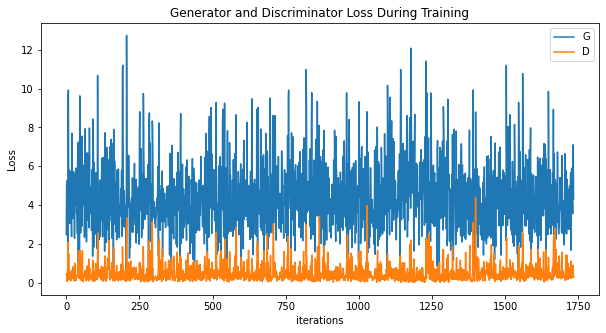

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_Loss,label="G")
plt.plot(D_Loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
h , w = 6, 16
with torch.no_grad():
  imlist = []
  z_list = []

  
  for step in range(max_step+1):
    z = nn.init.normal_(torch.Tensor(w,z_len),std=1).to(device)
    gen = generator.forward(z,1,2**(6))
    z_list.append(z.detach().cpu().numpy())
    imlist.append(np.transpose(gen.cpu().detach().numpy(),(0,2,3,1))*0.5+0.5)

  print(len(imlist))
  
  plt.figure(figsize=(60,22))
  for i in range(h):
    for j in range(w):
      plt.subplot(h,w,i*w+j+1)
      plt.imshow(imlist[i][j])

  
  plt.show()

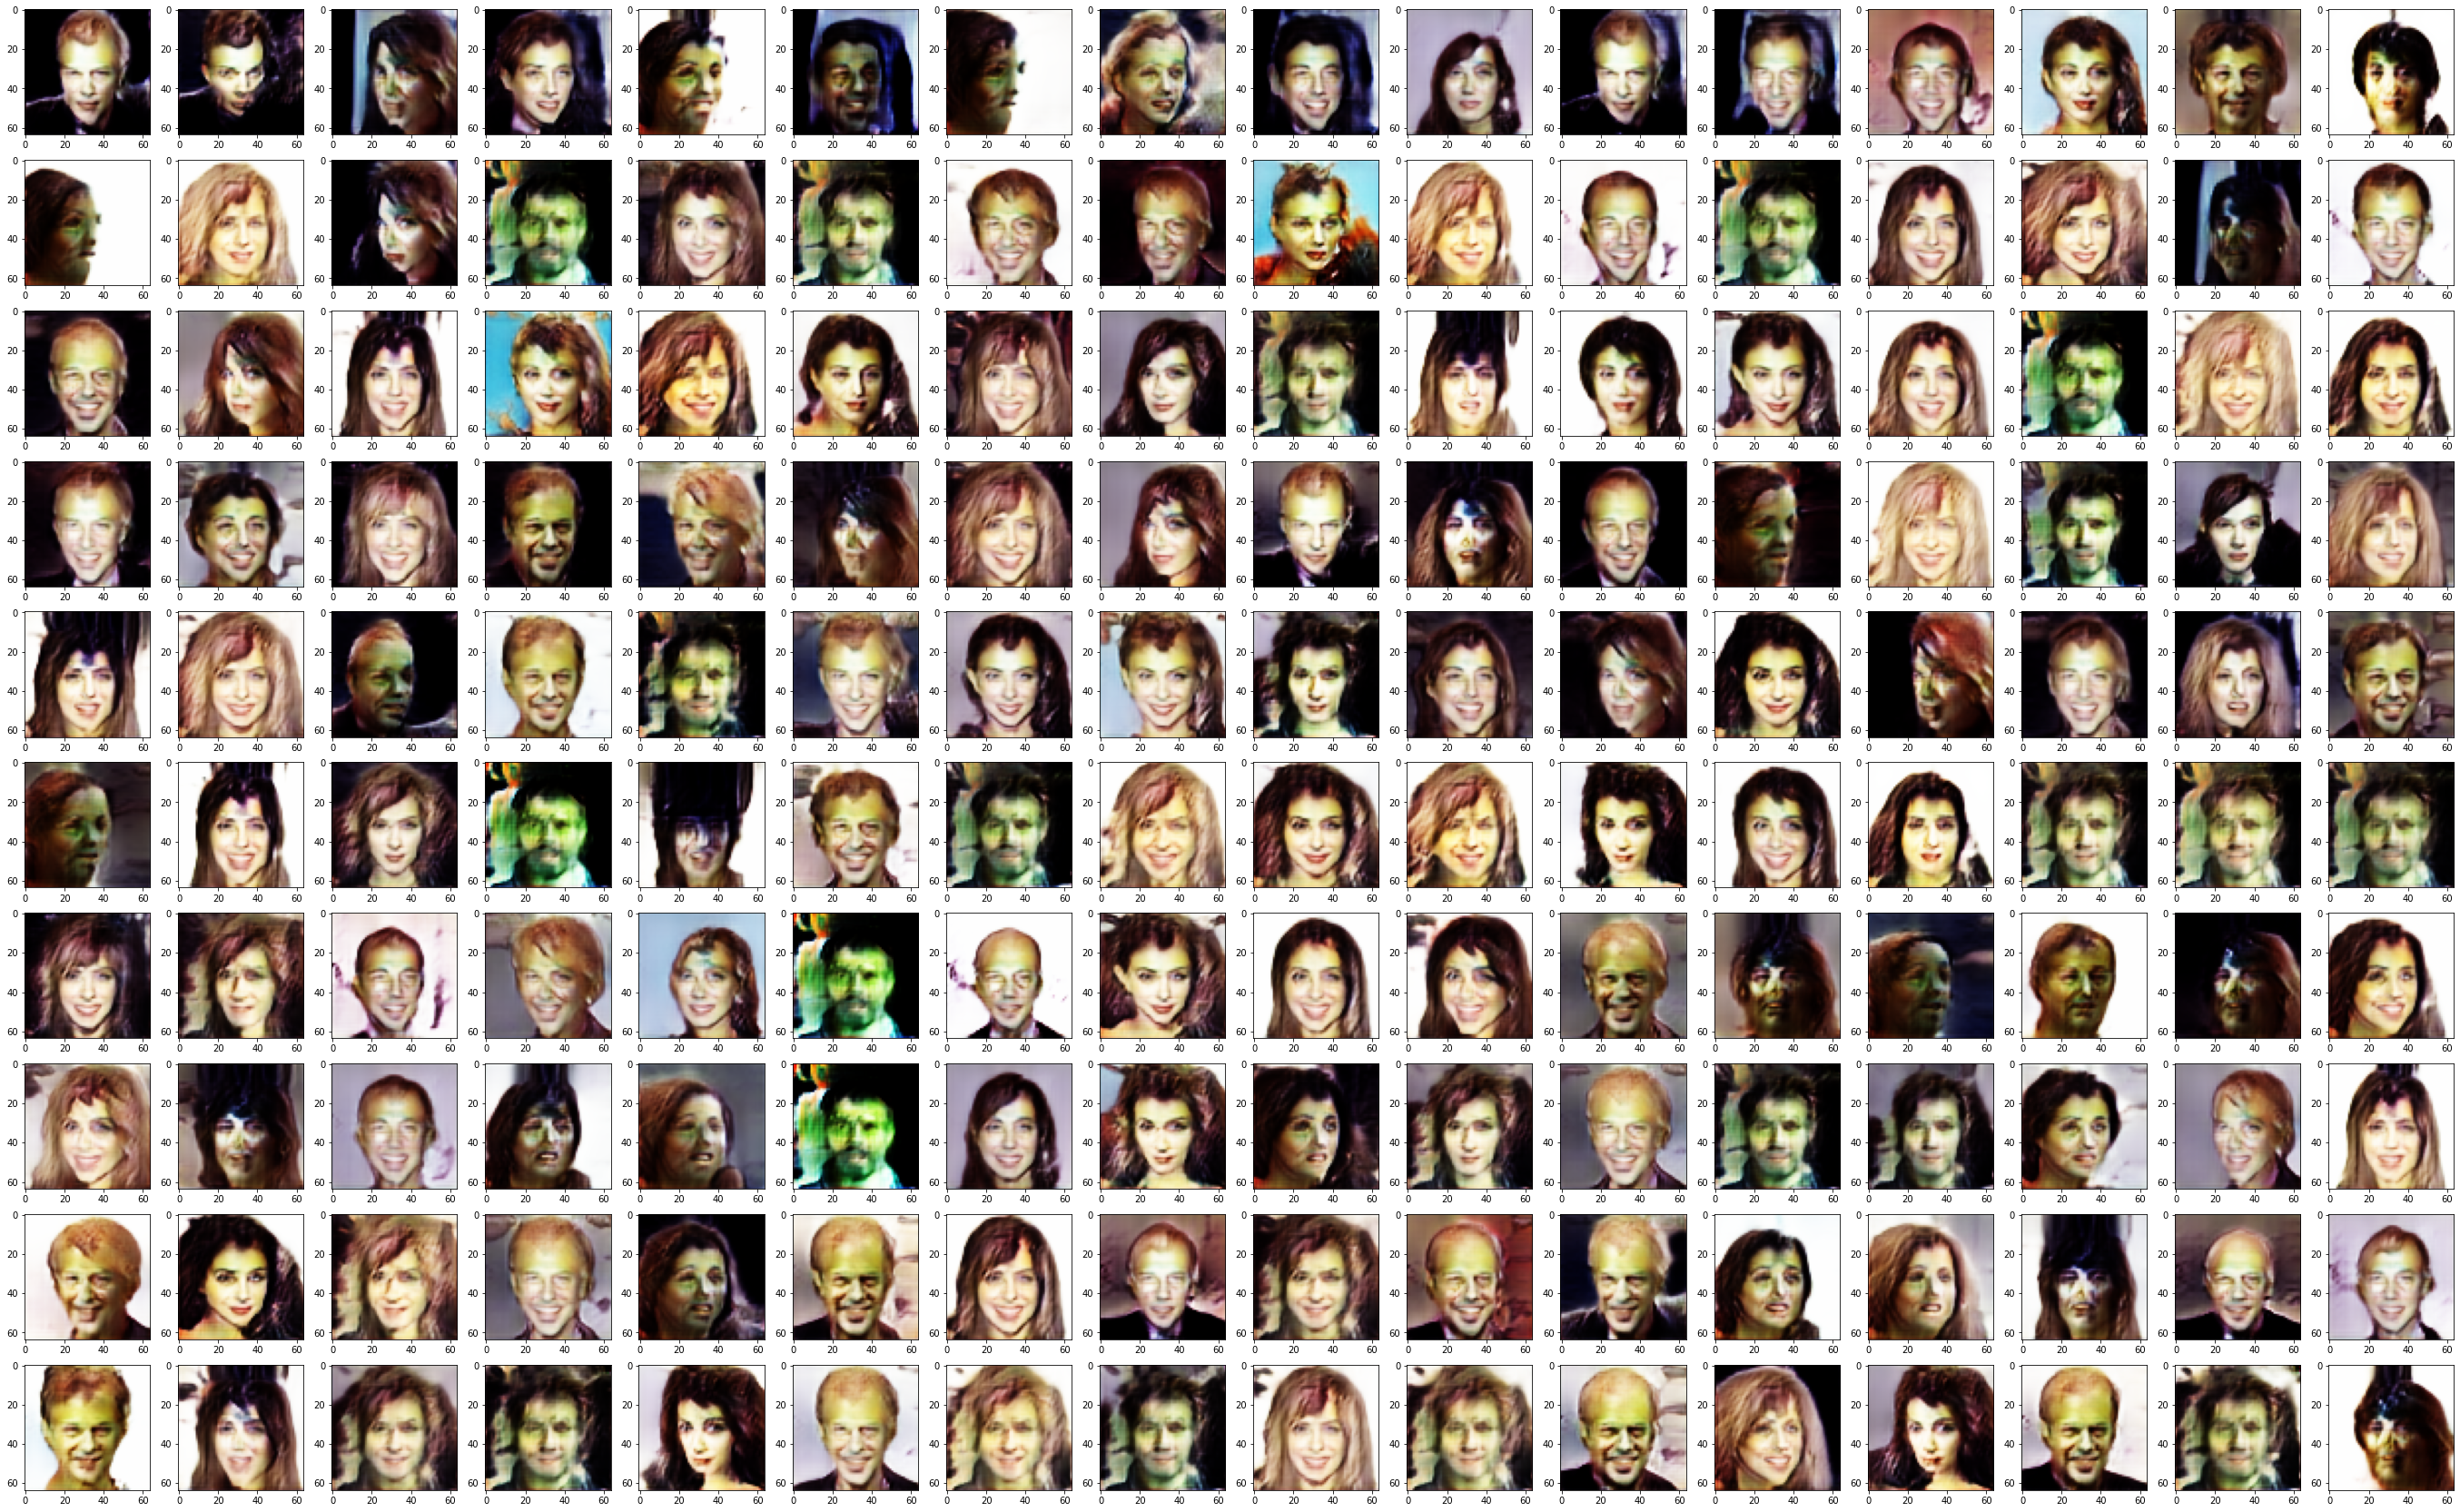

In [ ]:
h, w = 10,16
with torch.no_grad():
  z = nn.init.normal_(torch.Tensor(h*w,z_len),std=1).to(device)
  gen = generator.forward(z,1,2**6)
  dis = discriminator.forward(gen,1).view(-1)
  idx_map = [(i,a)for i,a in enumerate(dis.detach().cpu().numpy())]
  idx_map = np.array(idx_map,dtype=[('idx',int),('val',float)])
  idx_map = np.flip(np.sort(idx_map,order='val'))
  z = z.detach().cpu().numpy()
  gen = np.transpose(gen.cpu().detach().numpy(),(0,2,3,1))*0.5+0.5
  im_list = []
  z_list = []
  for i, j in idx_map:
    im_list.append(gen[i])
    z_list.append(z[i])

  plt.figure(figsize=(w*3,h*3))
  for i in range(h*w):
    plt.subplot(h,w,i+1)
    plt.imshow(im_list[i])

  plt.show()

In [ ]:
print(idx_map)

[( 85, 7.21456826e-01) (120, 6.91534638e-01) (122, 6.62624896e-01)
 ( 39, 6.24056518e-01) ( 65, 4.54923302e-01) ( 97, 4.35318381e-01)
 ( 79, 4.34663564e-01) ( 15, 4.26630378e-01) ( 28, 3.65824819e-01)
 (151, 3.57755870e-01) ( 43, 3.09425503e-01) ( 95, 2.74483353e-01)
 (145, 2.66551256e-01) (  7, 2.37043440e-01) ( 68, 2.31865853e-01)
 ( 59, 2.22695827e-01) (146, 2.20121115e-01) (109, 2.16995195e-01)
 ( 83, 2.16562748e-01) ( 11, 2.12301672e-01) (139, 2.11846396e-01)
 (115, 2.09534660e-01) ( 70, 2.05606490e-01) ( 87, 1.95880860e-01)
 (141, 1.89627483e-01) ( 54, 1.89095274e-01) ( 25, 1.81660771e-01)
 (119, 1.80104882e-01) (110, 1.65564463e-01) (118, 1.64339393e-01)
 ( 99, 1.60913900e-01) ( 61, 1.55405506e-01) (103, 1.52477384e-01)
 ( 18, 1.50645107e-01) (121, 1.47081852e-01) (143, 1.43168196e-01)
 ( 42, 1.42174914e-01) ( 80, 1.40103117e-01) (  4, 1.39168262e-01)
 ( 90, 1.35722741e-01) (116, 1.33876950e-01) (126, 1.33686423e-01)
 (105, 1.33235812e-01) ( 71, 1.26810789e-01) (124, 1.25472069e